# fitting experimental data


**Attention:** use a kernel from an conda/mamba environment where fenicsx is installed

The fit with the numerical model is relatively slow, because time step size is constant and not (yet) optimized



In [1]:
import sys
import time
import os
import math
import numpy as np
import scipy as sc
import pandas as pd
import matplotlib.pyplot as plt 
from copy import copy

Because the ADE_DG toolbox is (probably) not installed somewhere in the system we have to add the path to the location of the python code, either relative path of absolute path.

In [2]:
# import numerical toolbox ADE_DG for solving Advection-Diffusion-Equation specifically for trough-diffusion experiments
#import sys
sys.path.append("../sources") # include path to ../sources/ADE_DG1.py in path! -> this notebook is in ../notebooks/

# ADE_DG1.py must be in the path -> see path settings above
import ADE_DG
from ADE_DG import BoundaryCondition as BoundaryCondition # import BoundaryCondition in this way, otherwise it is not available ...

## Load experimental data

In principle one can load either text files or excel spreadsheets (requires openpyxl) with data. 
Best is to have data available in SI units, all other unit systems are not fail-save!
 * **times** in (s), relative to start of experiment
 * volumetric concentrations  (mol m⁻³) or (Bq m⁻³) or (kg m⁻³) 
 * all other measurements in the same unit system!




In [3]:
# load example dataset from Magick data
# define path to data directory
data_path="../../Magick-Data/Through diffusion data _Magic_2025/OPC26/"  
# data_path= "/mnt/c/Users/xi_b/3D Objects/suduko/290720251/Magick-Data/Through diffusion data _Magic_2025/OPC26/"
data_file_path="Experimental data_OPC26.ods"

#data_path = "/mnt/c/Users/xi_b/3D Objects/suduko/290720251/Magick-Data/Through diffusion data _Magic_2025/ESD20/"
#data_file_path = "Experimental data_ESD20.ods"
# Load data sets from excel file ...sheet name needs to be known...
# we have the first two rows (0 and 1) for header, take first row for name (no.0) and skip second row (no.1)
Cusb=pd.read_excel(data_path+data_file_path,sheet_name='Cusb',header=0,skiprows=[1])
Jdsb=pd.read_excel(data_path+data_file_path,sheet_name='Jdsb',header=0,skiprows=[1])
Makk=pd.read_excel(data_path+data_file_path,sheet_name='Makk',header=0,skiprows=[1])

# next commands remove trailing whitespaces from columns names
# these are a constant source of trouble, 
#because they are not visible if you print them, but are assumed part of column names
Cusb.columns=Cusb.columns.str.strip()
Jdsb.columns=Jdsb.columns.str.strip()
Makk.columns=Makk.columns.str.strip()

# convert to correct units...in the dataset  the times are in Days! 
# (see skipped second row in excel spreadshee)
# 1Day = 1.0*24*3600
Day_to_sec=24.0*3600
Cusb.Time=Cusb.Time*Day_to_sec
Jdsb.Time=Jdsb.Time*Day_to_sec

Makk.Time=Makk.Time*Day_to_sec
Makk.Accu=Makk.Accu*Day_to_sec
Makk['U(Accu)']=Makk['U(Accu)']*Day_to_sec

In [4]:
display(Cusb,Jdsb,Makk)
# meaning of names 
# Time in (s)
# Cusb concentration ustream boundary in (mol/m³)

,Time,Cusb,U(Cusb),Vhigh
0,0.000000e+00,0.000002,1.185347e-07,19.9634
1,3.443400e+05,0.000002,1.172375e-07,19.9136
2,8.768400e+05,0.000002,1.146135e-07,19.8633
3,1.554240e+06,0.000002,1.161075e-07,19.8128
4,2.156400e+06,0.000002,1.153999e-07,19.7642
5,2.778720e+06,0.000002,1.139443e-07,19.7138
6,3.368340e+06,0.000002,1.150209e-07,19.6634
7,3.978420e+06,0.000002,1.143098e-07,19.6132
8,4.418100e+06,0.000002,1.154624e-07,19.5627
9,5.197200e+06,0.000002,1.127417e-07,19.5116


,Time,JL,U(JL),Vlow
0,4.290000e+04,0.000000e+00,4.307374e-17,10.021
1,1.307400e+05,0.000000e+00,3.997594e-17,9.653
2,2.158800e+05,0.000000e+00,4.955385e-17,9.980
3,3.002100e+05,0.000000e+00,4.464265e-17,9.936
4,4.749300e+05,3.302417e-16,2.926315e-17,9.985
5,6.885300e+05,3.935459e-16,4.126927e-17,9.843
6,8.241900e+05,5.088438e-16,5.816691e-17,9.896
7,1.084740e+06,5.639572e-16,4.190633e-17,9.941
8,1.344150e+06,6.978680e-16,7.189790e-17,9.868
9,1.474950e+06,6.941983e-16,5.871355e-17,9.975


,Time,Accu,U(Accu),Zeit_s,Acum,u(Acum),Acum_m,U(Acum_m)
0,8.580000e+04,0.000000e+00,6.269653e-12,8.580000e+04,0.000000,0.077645,0.000000e+00,7.249768e-17
1,1.756800e+05,0.000000e+00,8.744313e-12,1.756800e+05,0.000000,0.108292,0.000000e+00,1.011128e-16
2,2.560800e+05,0.000000e+00,1.105197e-11,2.560800e+05,0.000000,0.136870,0.000000e+00,1.277968e-16
3,3.443400e+05,0.000000e+00,1.291612e-11,3.443400e+05,0.000000,0.159957,0.000000e+00,1.493525e-16
4,6.055200e+05,1.463240e-10,1.830143e-11,6.055200e+05,1.812114,0.226650,1.691983e-15,2.116243e-16
5,7.715400e+05,2.571647e-10,2.168050e-11,7.715400e+05,3.184794,0.268497,2.973664e-15,2.506974e-16
6,8.768400e+05,3.480631e-10,2.404189e-11,8.768400e+05,4.310504,0.297741,4.024747e-15,2.780028e-16
7,1.292640e+06,7.458718e-10,3.810275e-11,1.292640e+06,9.237070,0.471874,8.624715e-15,4.405923e-16
8,1.395660e+06,8.678377e-10,4.012122e-11,1.395660e+06,10.747527,0.496872,1.003504e-14,4.639324e-16
9,1.554240e+06,1.054594e-09,4.311852e-11,1.554240e+06,13.060368,0.533991,1.219455e-14,4.985910e-16


In the next cell we have to insert some values for the diffusion cell:

The values are used (partly) for calculations, therefore units need to follwo SI..
Here I made a screenshot from spreadsheet for OPC26
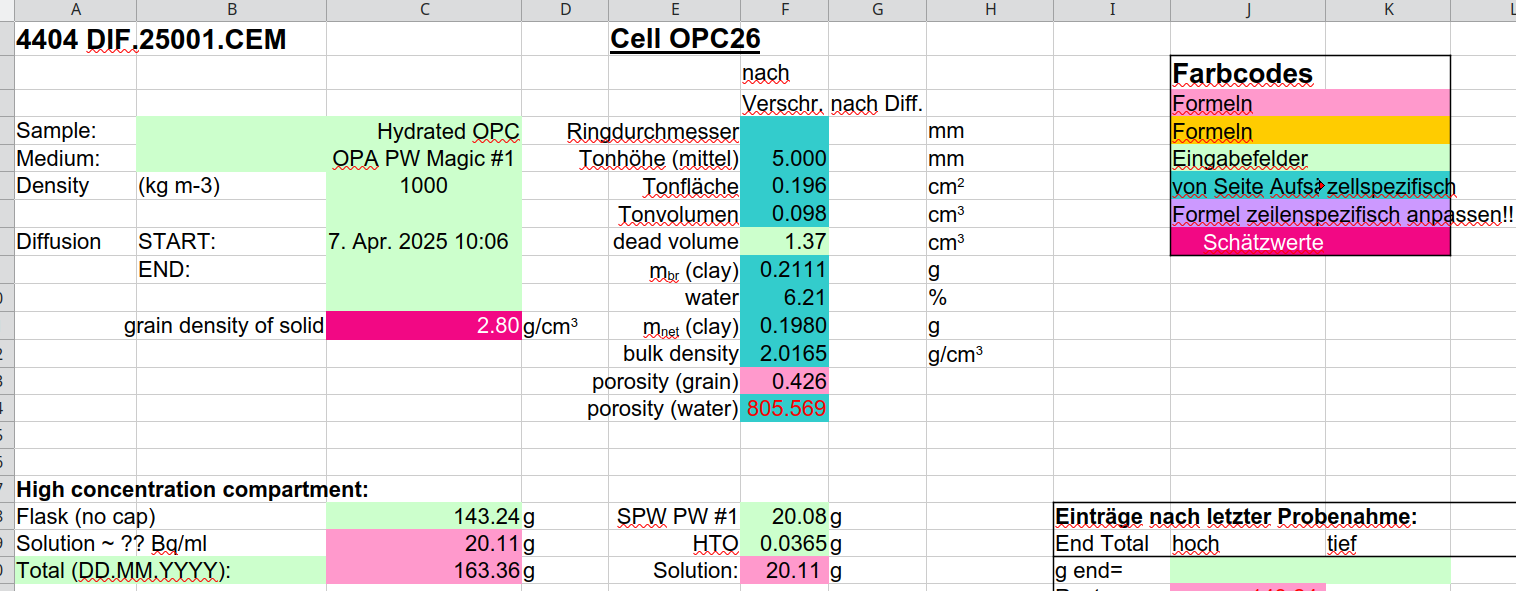
and here the right side with some uncertainties for measurements
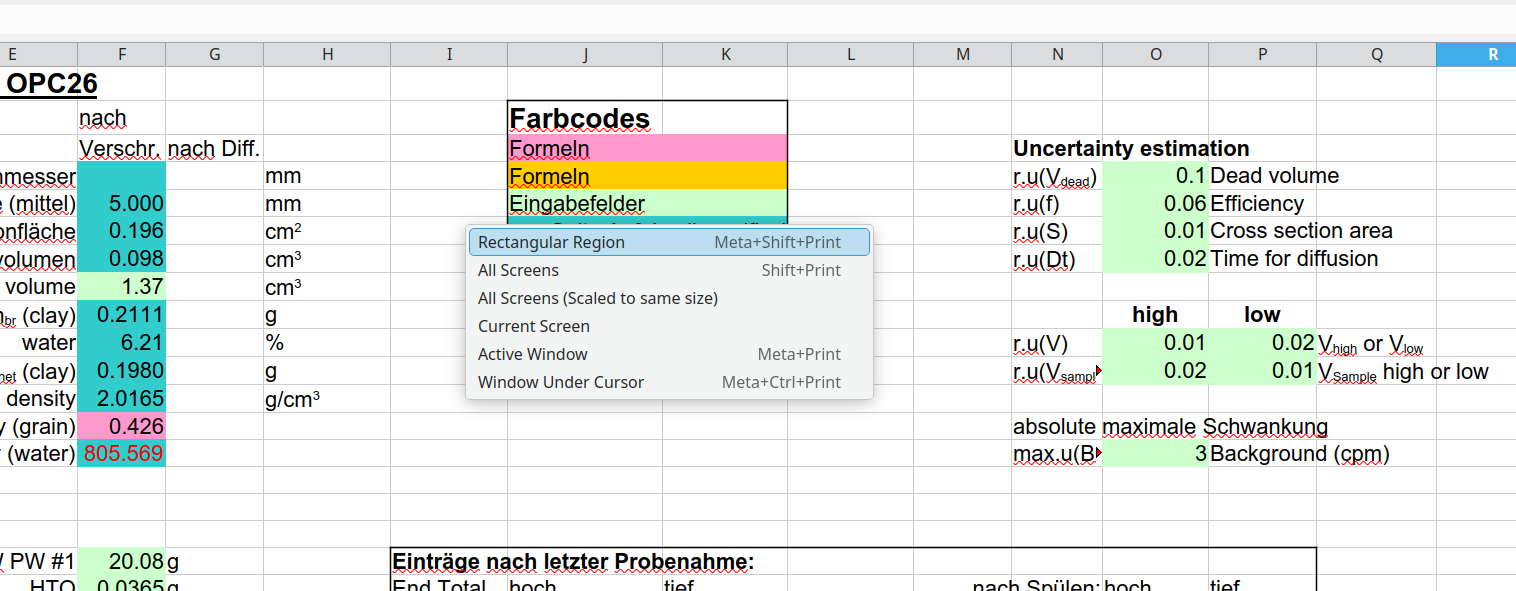

Experiment was conducted at 40°C
Temperature influence on reservoir volumes was not considered for estimation of experimental results..
Dead volume (missing filters) was not considered for reservoir volumes!



In [5]:
#sample thickness
sample_thickness=5e-3 # unit (m) = 5 mm
cross_section_area = 0.196e-4 # unit (m²) 0.196 cm * cm
# first attempt: we start with constant reservoir volumes
upstream_volume=Cusb.Vhigh[0]
downstream_volume=Jdsb.Vlow[0]
upstream_concentration=Cusb['Cusb'][0]
downstream_concentration=0.0

# we normalize for fitting the concentrations/fluxes by upstream_concentration to make it easier for the adaptive time stepping to control time step size!

# select fitting parameter for breakthrough
tdat=Jdsb.Time[:]   # to use only part of the values for fitting please use Jdsb.Time[0.20] for the first 20 Entries only
fdat=Jdsb.JL[:]  # downstram fluxes
fcdat=sc.integrate.cumulative_trapezoid(fdat,tdat,initial=0.0) # integrated downstream fluxes

# convenience array for plotting of uncertainty if not all datapoints are used for fitting
fdatU=Jdsb['U(JL)'][:]

# to reset downstream concentration to "zero" we create an array of times 
t_down_rest=np.array(Makk.Time)
#t_down_rest=[1.0e11]
print(t_down_rest)

[  85800.00000056  175680.00000059  256080.00000052  344340.00000029
  605520.00000046  771540.00000036  876840.00000036 1292640.00000036
 1395660.00000047 1554240.00000002 1811880.00000058 1987800.00000007
 2156400.00000021 2415480.00000045 2608620.00000011 2778720.00000011
 3020220.00000025 3199260.00000047 3368340.0000003  3626940.00000022
 3804840.0000005  3978420.00000053 4252440.00000044 4418100.00000042
 4837440.00000002 5025060.00000055 5197200.00000028 5609640.00000002
 5783700.00000035 6043320.00000046 6225840.00000008 6651540.0000003 ]


## Create and initialize function for numerical solver

One has to initialize and create a function that can be called from the fitting routine. 

The basic setup is based on mesh that was created with gmsh:

    * The dimensions of the mesh should be choosen that they represent the dimensions of the diffusion cell, filters, sample.
    * The different materials (sample, filter) and the influx (upstream) and outflux (downstream) boundaries have to be marked with "physical group Ids"
    * It is assumed the the upstream boundary is at x=0m and the downstream boundary at x = "lenght of sample + filters" in positive x-direction

The numerical solver is initialized via the ADE_DG call that reads the mesh from a file and requires a parameter that sets the "degree" of DG elements.

For the numerical setup the follwing parameters have to be defined and passed to the code:

    * material parameters
        - De and porosity/alpha for all materials (filter,sample)
        - Cross sectional area of the sample/filters
    * initial conditions
       - Initial concentrations everywhere in the domain
    * boundary conditions
        - position of the boundaries and their physical group id (marker no.)
        - initial concentrations in the Upstream and Downstream reservoirs
        - volume of the reservoirs
        - A flag that sets constant (boundary) concentrations in the reservoir: set_reservoir_boundaries(False), 
        or adjusts reservoir concentrations according to fluxes out of or into the reservoir: set_reservoir_boundaries(True)
        


In [6]:
# general definitions    
hour=3600.0
day=hour*24.0
year=day*365.25

# filename for gmsh file
mymesh_filename = "./gmsh/Magick1D.msh"
# define problem
# degree of desired FE is moved into ADE_DG
problem = ADE_DG.ADE_DG(mymesh_filename,deg=2)
problem.set_tol_adaptive(1.0e-12) #some default value for error tolerance used in adaptive time stepping loop

# define everything once

# initial conditions
C0=0.0 # initial condition

# effective Diffusion for all marked materials
# we introduce default values
# markers can be found in gmsh geo file
De=1.0e-11
De_dict={
    5 : 1.0e-11,   #sample
}

# porosity/alpha ..this are default values
alpha=0.1
porosity_dict={
    5 : alpha    #sample
}
# if diffusion only the Darcy flux is 0.0 (zero) for all components
darcy_flux_vector = (0.0,0.0) # list  will work ...

# initial condition
C0=0.0
problem.set_initial_conditions(C0)

problem.set_darcy_flux(darcy_flux_vector)
problem.set_De(De_dict)
problem.set_porosity(porosity_dict)
# write materials in specific vtx file (do not use the same file as for time steps. this will overwrite file=
#problem.vtx_write_materials(filename_vtx_materials,t=0.0) 
problem.set_upstream_boundary(3,0.0) # should be "left boundary"
problem.set_upstream_reservoir_concentration(upstream_concentration) # will be overwritten in flux_model function
problem.set_upstream_reservoir_volume(upstream_volume)
problem.set_downstream_boundary(4,0.005) # should be "right  boundary"
problem.set_downstream_reservoir_concentration(0.0) # will be overwritten in flux_model function
problem.set_downstream_reservoir_volume(downstream_volume)
problem.set_update_reservoir_boundaries(True) # if up-stream and down-stream reservoirs should be defined ..needs defintion of reservoir properties
problem.set_downstream_reservoir_exchange_solution_times(t_down_rest)
problem.set_cross_section_area(cross_section_area) # 1 for comparison with analytical solution

problem.set_tol_adaptive(1.0e-8) # tolerance for adaptive time stepping

INFO:root:INFO: init with: ./gmsh/Magick1D.msh deg 2
INFO:root:INFO: mesh read! mesh dimension: 1 boundary dimension 0 geometry dimension: 2
INFO:root:Darcy flux is set to: (0.0, 0.0) for the whole domain.
INFO:root:INFO: De set via dictionary {5: 1e-11} default: 1.0e-11 
INFO:root:porosity set via dictionary {5: 0.1} default: 1.0


Info    : Reading './gmsh/Magick1D.msh'...
Info    : 3 entities
Info    : 18 nodes
Info    : 19 elements
Info    : Done reading './gmsh/Magick1D.msh'


In [7]:
def flux_model(tdat,alpha,De):
    print("flux_model: called with alpha,De",alpha,De)

    # this can be moved out of the loop , at least in principle
    problem.set_update_reservoir_boundaries(True) # if up-stream and down-stream reservoirs should be defined ..needs defintion of reservoir properties
    problem.set_upstream_boundary(3,0.0) # should be "left boundary"
    problem.set_downstream_boundary(4,0.005) # should be "right  boundary"
#    problem.set_tol_adaptive(1.0e-8)  
    #### definitions for ADE-DG solutions that need to be re-set for multiple runs
    # only reset everything that is changed during simulations or due to call -> alpha
    C0=0.0 # initial concentration 
    
    # porosity
    porosity_dict={
        5 : alpha  #sample   
    }
    # De
    De_dict={
        5 : De   #sample
    }
    u_old=problem.set_initial_conditions(C0)
    
    problem.set_porosity(porosity_dict)
    problem.set_De(De_dict)
    
    problem.set_downstream_reservoir_exchange_solution_times(t_down_rest)
    problem.set_upstream_reservoir_concentration(upstream_concentration)    
    problem.set_downstream_reservoir_concentration(0.0)
    
    # Time stepping
    t_end=max(tdat)
    dt=1000.0
    problem.set_dt(dt)
    problem.set_T_end(t_end)

    solution,data=problem.solve_adaptive_timesteps()
    #solution,data=problem.solve_timesteps() # fixed time stepping scheme! solution is fenics Function(V) object, while data is a pandas data frame
    # add integrates downstream fluxes for fitting
    data['Downstream_flux_integr']=sc.integrate.cumulative_trapezoid(data.Downstream_flux,data.time,initial=0.0) # fluxes and concentrations need to be scaled back if used directly...

    # for time interpolation we can use np.interpolate
    flux=np.interp(tdat, data.time, np.abs(data.Downstream_flux))
# for fitting integrated data!
#    flux=np.interp(tdat, data.time, np.abs(data.Downstream_flux_integr)) 


    #print("Debug: solution, data, flux ",solution,data,flux)
    return (flux) 

In [8]:
problem.set_tol_adaptive(1.0e-7) # tolerance for adaptive time stepping
problem.set_logging_enabled() # enable logging
myflux=flux_model(tdat,0.45,2.5e-12)
problem.set_logging_disabled() # disable again

INFO:root:porosity set via dictionary {5: 0.45} default: 1.0
INFO:root:INFO: De set via dictionary {5: 2.5e-12} default: 1.0e-11 


flux_model: called with alpha,De 0.45 2.5e-12


INFO:root:INFO: Adaptive time loop starts with error tolerance: 1e-07 update_reservoir_concentrations: True
INFO:root:INFO: t dt error est     0.0000 |  1000.0000 |  1.379e-09
INFO:root:INFO: t dt error est  1000.0000 |  8079.5923 |  1.977e-09
INFO:root:INFO: t dt error est  9079.5923 | 54513.9772 |  2.243e-09
INFO:root:INFO: t dt error est 63593.5695 | 22206.4305 |  3.812e-10
INFO:root:INFO: t dt error est 85800.0000 | 89880.0000 |  3.743e-10
INFO:root:INFO: t dt error est 175680.0000 | 80400.0000 |  2.636e-10
INFO:root:INFO: t dt error est 256080.0000 | 88260.0000 |  2.341e-10
INFO:root:INFO: t dt error est 344340.0000 | 261180.0000 |  2.718e-10
INFO:root:INFO: t dt error est 605520.0000 | 166020.0000 |  2.097e-10
INFO:root:INFO: t dt error est 771540.0000 | 105300.0000 |  1.942e-10
INFO:root:INFO: t dt error est 876840.0000 | 415800.0000 |  2.147e-10
INFO:root:INFO: t dt error est 1292640.0000 | 103020.0000 |  1.748e-10
INFO:root:INFO: t dt error est 1395660.0000 | 158580.0000 |  1.

Logging is disabled!


In [9]:
display(myflux)

array([7.50210325e-20, 3.09217546e-17, 9.72711827e-17, 2.94319512e-16,
       5.19553109e-16, 6.27564690e-16, 7.44593713e-16, 8.37539034e-16,
       8.61064635e-16, 8.86835412e-16, 9.05474964e-16, 9.14584507e-16,
       9.21692259e-16, 9.26763273e-16, 9.29258939e-16, 9.31026151e-16,
       9.32257888e-16, 9.32898179e-16, 9.33390875e-16, 9.33734740e-16,
       9.33904005e-16, 9.34037351e-16, 9.34127416e-16, 9.34185025e-16,
       9.34225754e-16, 9.34237545e-16, 9.34247919e-16, 9.34255034e-16,
       9.34257430e-16, 9.34259082e-16, 9.34260191e-16, 9.34260805e-16])

## One manual run to test parameters

Before one does possibly time consuming fitting, it makes sense to once run the model to check input parameters and if the model runs at all.



In [10]:

t_real= max(tdat) #np.pow(t,10.0)

#### definitions for ADE-DG solutions that need to be re-set for multiple runs
# only reset everything that is changed during simulations or due to call -> alpha
C0=0.0 # initial concentration 
De =2.5e-12
alpha =0.45
# porosity
porosity_dict={
    5 : alpha  #sample   
}
De_dict={
    5 : De   #sample
}
u_old=problem.set_initial_conditions(C0)
u_new=copy(u_old) # make a copy for u_new

problem.set_porosity(porosity_dict)
problem.set_De(De_dict)

problem.set_upstream_boundary(3,0.0) # should be "left boundary"
problem.set_upstream_reservoir_concentration(upstream_concentration)

problem.set_downstream_boundary(4,0.005) # should be "right  boundary"
problem.set_downstream_reservoir_concentration(0.0)

problem.set_update_reservoir_boundaries(True) # if up-stream and down-stream reservoirs should be defined ..needs defintion of reservoir properties

problem.set_logging_level("INFO") # This gives some information on time steps and time step sizes!

# Time stepping
t_end=max(tdat)
dt=1000.0
problem.set_dt(dt)
problem.set_T_end(t_end)
problem.set_tol_adaptive(1.0e-10)
#problem.set_dtmax=(t_end/10)
#problem.set_vtx_filename(filename_vtx, 10)
solution,data=problem.solve_adaptive_timesteps()

# for fitting integrated data!
#    flux=np.interp(t_real, data.time, np.abs(data.Downstream_flux_integr)) 

set logging to level:  INFO


In [11]:
# add integrates downstream fluxes for fitting
dumy=np.array(data.Downstream_flux)*-1.0
dumx=np.array(data.time)
#display(dumx,dumy)
data['Downstream_flux_integr']=sc.integrate.cumulative_trapezoid(data.Downstream_flux,data.time,initial=0.0)
#display(np.trapezoid(y=dumy,x=dumx))
test=np.interp(tdat, data.time, -1.0*(data.Downstream_flux))
#display(data,test)

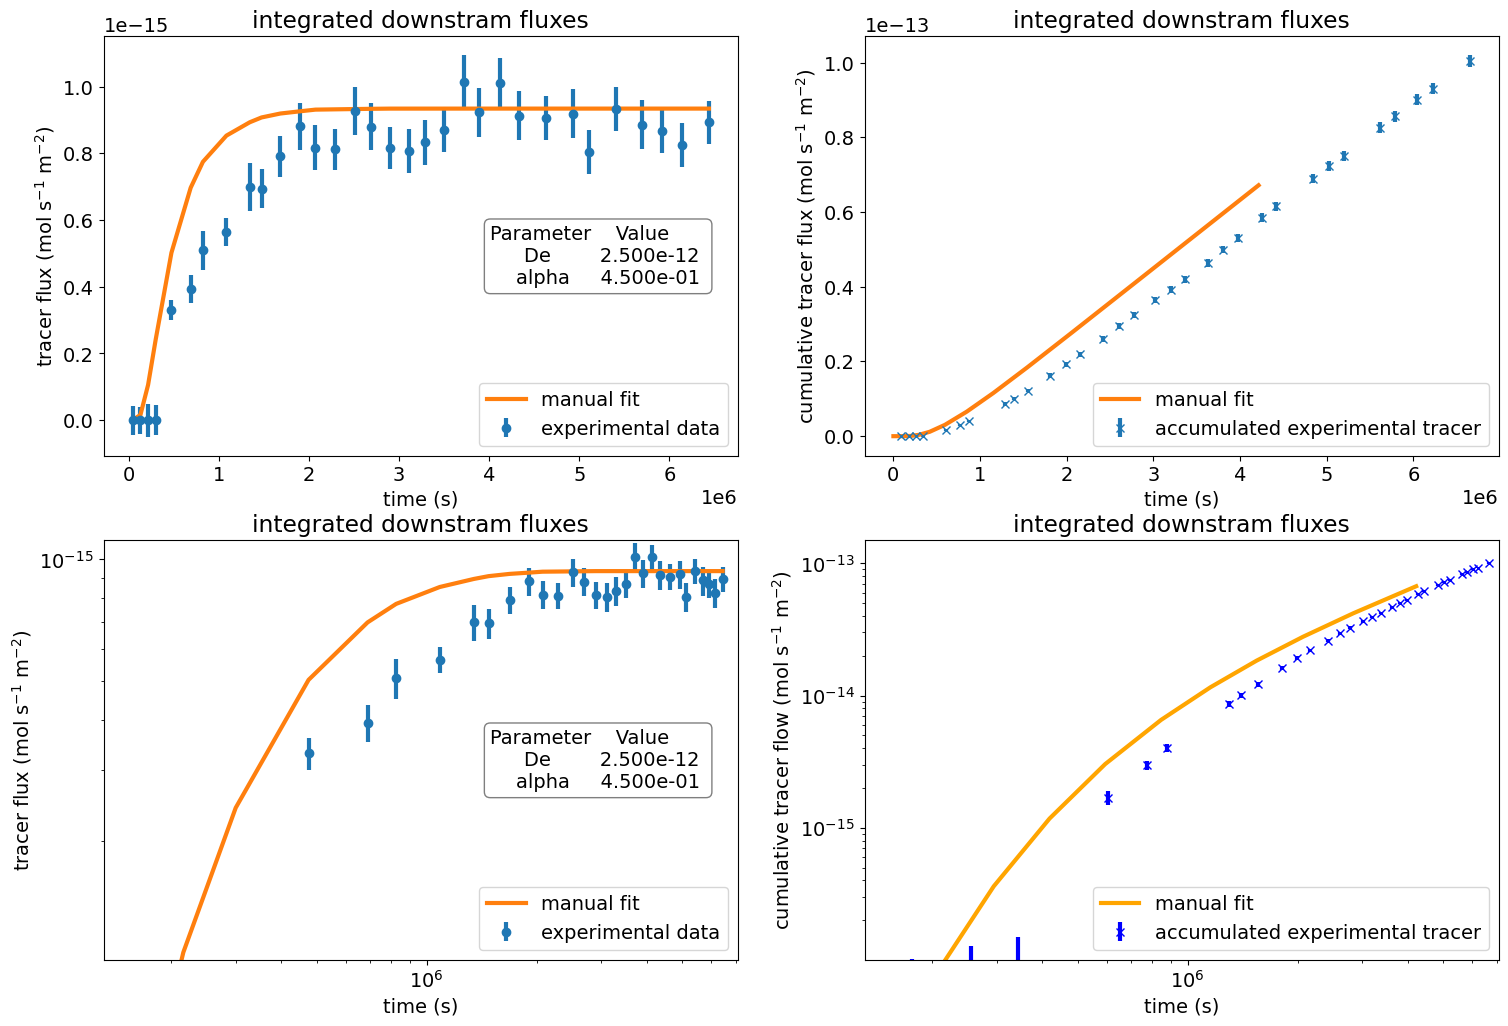

In [15]:
# We plot the fluxes ...aka breakthrough
# general plotting parameters
plt.rcParams["figure.figsize"] = [18, 12]
plt.rcParams.update({'lines.linewidth':3}) # plt parameters are used also for next plots! -> change again if necessary
plt.rcParams.update({'font.size': 14}) # update font size..default is 10 !
# create two subplots
fig, ax = plt.subplots(2,2)
#----- LEFT PLOT --------
ax[0,0].errorbar(tdat, fdat,yerr=fdatU,fmt= 'o',label='experimental data')

#plt.plot(tdat, result_analytic.init_fit, '--', label='initial fit')
ax[0,0].plot(tdat, test, '-', label='manual fit')
#add textbox with information
textstr = '\n'.join((
    'Parameter    Value      ',
    f'{'De   ':7s} {De:11.3e} ',
    f'{'alpha':7s} {alpha:11.3e} '))
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
# place a text box in lower right in axes coords
ax[0,0].text(0.95 ,0.4, textstr, fontsize=14,transform=ax[0,0].transAxes, horizontalalignment='right',verticalalignment='bottom',bbox=props)
#
ax[0,0].set_title('downstram fluxes')
ax[0,0].set_title('integrated downstram fluxes')
ax[0,0].set_xlabel('time (s)')
ax[0,0].set_ylabel('tracer flux (mol s$^{-1}$ m$^{-2}$)')
ax[0,0].legend( facecolor='white',loc="lower right")
#################### TOP ROW######################
#----- RIGHT PLOT --------
#ax[0,1].plot(tdat, fcdat*cross_section_area, 'o',label='accumulated experimental flux')
#ax[0,1].errorbar(Makk.Time, Makk.Accu*cross_section_area, yerr=Makk['U(Accu)']*cross_section_area,fmt='x',label='accumulated experimental data')
ax[0,1].errorbar(Makk.Time, Makk.Acum_m, yerr=Makk['U(Acum_m)'],fmt='x',label='accumulated experimental tracer')

#plt.plot(tdat, result_analytic.init_fit, '--', label='initial fit')
ax[0,1].plot(data.time, np.abs(data.Downstream_flux_integr)*cross_section_area, '-', label='manual fit')
#add textbox with information
textstr = '\n'.join((
    'Parameter    Value      ',
    f'{'De   ':7s} {De:11.3e} ',
    f'{'alpha':7s} {alpha:11.3e} '))
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
# place a text box in lower right in axes coords
#ax[0,1].text(0.95 ,0.4, textstr, fontsize=14,transform=ax[0,0].transAxes, horizontalalignment='right',verticalalignment='bottom',bbox=props)
#
ax[0,1].set_title('integrated downstram fluxes')
ax[0,1].set_xlabel('time (s)')
ax[0,1].set_ylabel('cumulative tracer flux (mol s$^{-1}$ m$^{-2}$)')
ax[0,1].legend( facecolor='white',loc="lower right")
########################Bottom ROW #########################
#----- LEFT PLOT --------

ax[1,0].errorbar(tdat, fdat,yerr=fdatU,fmt= 'o',label='experimental data')
#plt.plot(tdat, result_analytic.init_fit, '--', label='initial fit')
ax[1,0].plot(tdat, test, '-', label='manual fit')
#add textbox with information
textstr = '\n'.join((
    'Parameter    Value      ',
    f'{'De   ':7s} {De:11.3e} ',
    f'{'alpha':7s} {alpha:11.3e} '))
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
# place a text box in lower right in axes coords
ax[1,0].text(0.95 ,0.4, textstr, fontsize=14,transform=ax[1,0].transAxes, horizontalalignment='right',verticalalignment='bottom',bbox=props)
#
ax[1,0].set_xscale('log')
ax[1,0].set_yscale('log')
ax[1,0].set_xlim((tdat[1],max(tdat)*1.1))
ax[1,0].set_ylim((max(fdat)*1.0e-1,max(fdat)*1.1))
ax[1,0].set_title('downstram fluxes')
ax[1,0].set_title('integrated downstram fluxes')
ax[1,0].set_xlabel('time (s)')
ax[1,0].set_ylabel('tracer flux (mol s$^{-1}$ m$^{-2}$)')
ax[1,0].legend( facecolor='white',loc="lower right")

#----- RIGHT PLOT --------
#ax[1,1].loglog(tdat, test, '-', label='manual fit')
ax[1,1].loglog(data.time, np.abs(data.Downstream_flux_integr)*cross_section_area, '-', label='manual fit',color="orange")
ax[1,1].errorbar(Makk.Time, Makk.Acum_m, yerr=Makk['U(Acum_m)'],fmt='x',label='accumulated experimental tracer',color='blue')

#plt.plot(tdat, result_analytic.init_fit, '--', label='initial fit')

#add textbox with information
textstr = '\n'.join((
    'Parameter    Value      ',
    f'{'De   ':7s} {De:11.3e} ',
    f'{'alpha':7s} {alpha:11.3e} '))
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
# place a text box in lower right in axes coords
#ax[0,1].text(0.95 ,0.4, textstr, fontsize=14,transform=ax[0,0].transAxes, horizontalalignment='right',verticalalignment='bottom',bbox=props)
#
ax[1,1].set_xlim((tdat[1],max(tdat)*1.1))
ax[1,1].set_ylim((max(Makk.Acum_m)*1.0e-3,max(Makk.Acum_m)*1.5))
ax[1,1].set_title('integrated downstram fluxes')
ax[1,1].set_xlabel('time (s)')
ax[1,1].set_ylabel('cumulative tracer flow (mol s$^{-1}$ m$^{-2}$)')
ax[1,1].legend( facecolor='white',loc="lower right")


plt.show()

## Fitting with LMFIT

https://lmfit.github.io/lmfit-py/intro.html

The lmfit package provides simple tools to help you build complex fitting models for non-linear least-squares problems and apply these models to real data.

**Install lmfit-py with** **"mamba install lmfit"**

Why use lmfit?

While scipy offers an standard approach to optimization and curve fitting, LMFIT is a specialised tool that offers better support for advanced methods and diagnostic tools!


In [16]:

import lmfit as lmfit

#params = lmfit.Parameters()
#params.add('alpha', 0.6) # starting value for fit
#params.add('De', value=3.0e-12) # starting value for fit



In [17]:
# we can set number of time steppings via adaptive tolerance
problem.set_update_reservoir_boundaries(True)
problem.set_tol_adaptive(1.0e-7)
problem.set_logging_level("ERROR") # This gives some information on time steps and time step sizes!

ademodel=lmfit.Model(flux_model)
print(f'parameter names: {ademodel.param_names}')
print(f'independent variables: {ademodel.independent_vars}')

#ademodel.set_param_hint('alpha', min=1.0e-4)
#ademodel.set_param_hint('De', min=1.0e-15,max=1.0e-9)
# here we fit the data
result_ademodel=ademodel.fit(fdat, tdat=tdat, alpha=0.3,De=2.0e-12)
# result_ademodel=ademodel.fit(fdat, tdat=tdat, weights=1.0/fdatU,alpha=0.3,De=2.0e-12)
# here we calculate uncertainty values
dely = result_ademodel.eval_uncertainty(sigma=3)

print(result_ademodel.fit_report())


set logging to level:  ERROR
parameter names: ['alpha', 'De']
independent variables: ['tdat']
flux_model: called with alpha,De 0.3 2e-12
flux_model: called with alpha,De 0.3 2e-12
flux_model: called with alpha,De 0.3 2e-12
flux_model: called with alpha,De 0.3 2e-12
flux_model: called with alpha,De 0.30000299999999996 2e-12
flux_model: called with alpha,De 0.3 2.0000199999999998e-12
flux_model: called with alpha,De 0.5705816292578907 2.332892872017845e-12
flux_model: called with alpha,De 0.5705873350741832 2.332892872017845e-12
flux_model: called with alpha,De 0.5705816292578907 2.332916200946565e-12
flux_model: called with alpha,De 0.6595905260733601 2.3995231716412837e-12
flux_model: called with alpha,De 0.6595971219786209 2.3995231716412837e-12
flux_model: called with alpha,De 0.6595905260733601 2.399547166873e-12
flux_model: called with alpha,De 0.6630054499630514 2.4026204156251877e-12
flux_model: called with alpha,De 0.6630120800175511 2.4026204156251877e-12
flux_model: called wit

In [18]:


#plt.fill_between(x, result.best_fit-dely, result.best_fit+dely, color="#ABABAB",
#                 label=r'3-$\sigma$ uncertainty band')
# add integrates downstream fluxes for plotting
dumy=np.array(result_ademodel.best_fit)
dumx=np.array(tdat)
print(dumx,dumy)
best_fit_integr=sc.integrate.cumulative_trapezoid(y=dumy,x=dumx,initial=0.0)

[  42900.00000028  130740.00000057  215880.00000055  300210.00000041
  474930.00000038  688530.00000041  824190.00000036 1084740.00000036
 1344150.00000042 1474950.00000025 1683060.0000003  1899840.00000033
 2072100.00000014 2285940.00000033 2512050.00000028 2693670.00000011
 2899470.00000019 3109740.00000036 3283800.00000038 3497640.00000026
 3715890.00000036 3891630.00000052 4115430.00000048 4335270.00000042
 4627770.00000022 4931250.00000028 5111130.00000041 5403420.00000014
 5696670.00000019 5913510.00000041 6134580.00000027 6438690.00000019] [3.23708487e-21 3.58694288e-18 1.79232758e-17 1.11545093e-16
 2.57647173e-16 3.58757998e-16 5.06484673e-16 6.36152716e-16
 6.79862951e-16 7.34280361e-16 7.79021396e-16 8.05060104e-16
 8.28883951e-16 8.48364400e-16 8.59786764e-16 8.69300747e-16
 8.76875713e-16 8.81522127e-16 8.85719034e-16 8.89062178e-16
 8.91023795e-16 8.92844366e-16 8.94246087e-16 8.95396954e-16
 8.96326062e-16 8.96677066e-16 8.97055877e-16 8.97352520e-16
 8.97485537e-16 8.97

### Plotting results

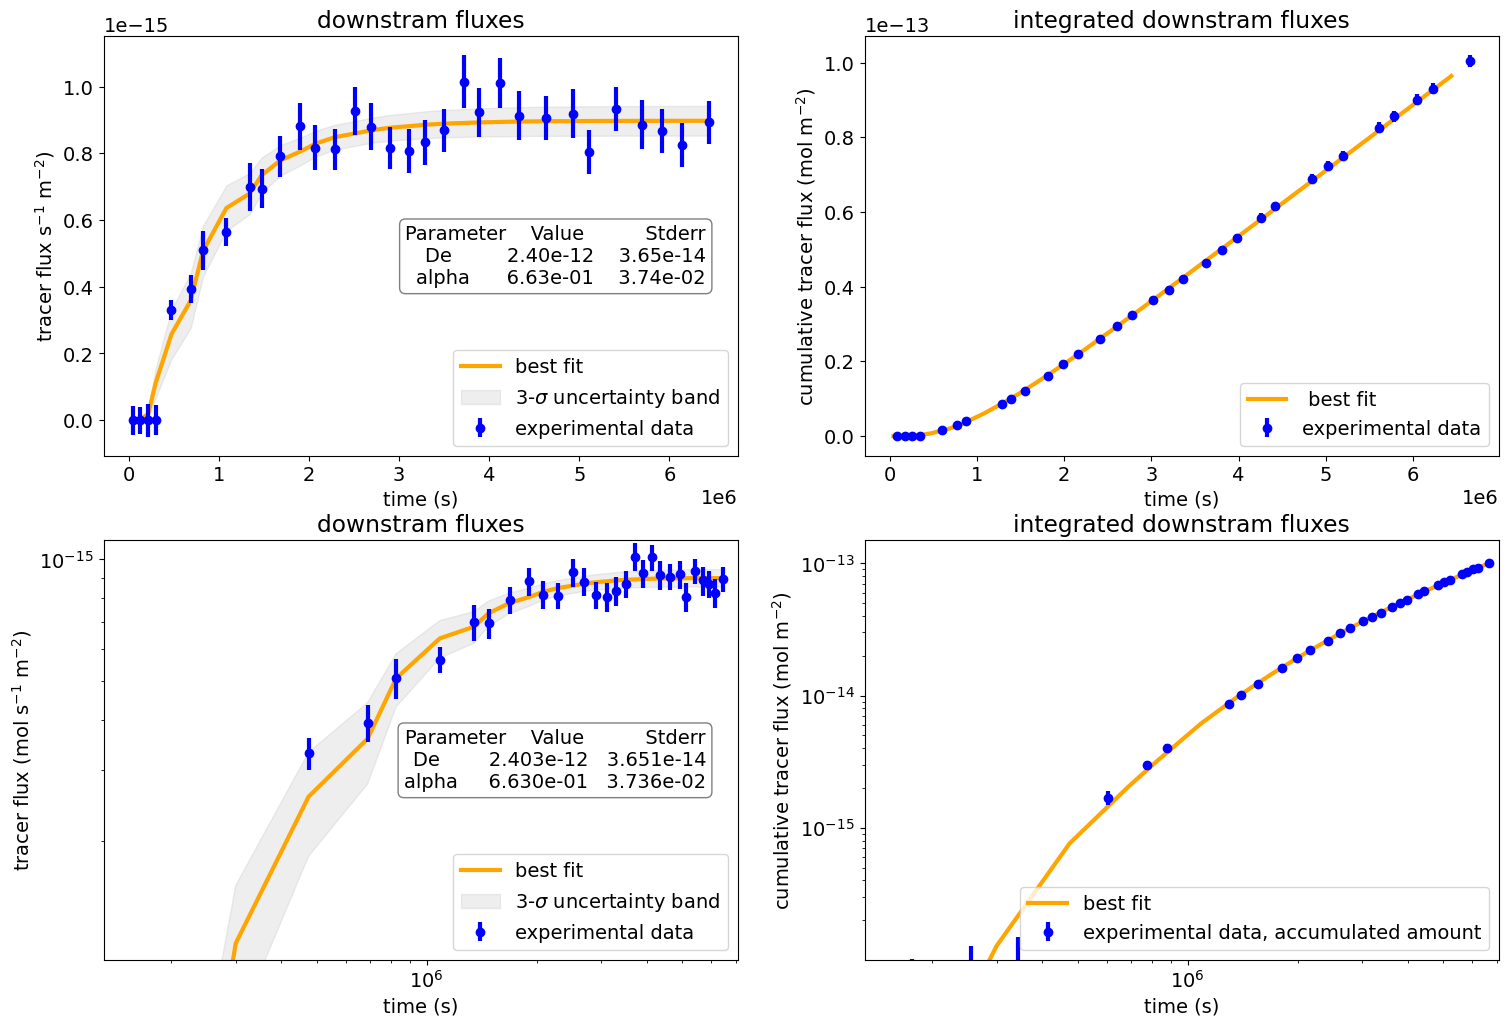

In [24]:
# We plot the fluxes ...aka breakthrough
# general plotting parameters
plt.rcParams["figure.figsize"] = [18, 12]
plt.rcParams.update({'lines.linewidth':3}) # plt parameters are used also for next plots! -> change again if necessary
plt.rcParams.update({'font.size': 14}) # update font size..default is 10 !
# create two subplots
fig, ax = plt.subplots(2,2)

########### UPPER ROW #############
#----- LEFT PLOT --------
ax[0,0].plot(tdat, result_ademodel.best_fit, '-', label='best fit', color='orange')
ax[0,0].errorbar(tdat, fdat,yerr=fdatU,fmt= 'o',label='experimental data',color='blue')
#plt.plot(tdat, result_analytic.init_fit, '--', label='initial fit')
ax[0,0].fill_between(tdat, result_ademodel.best_fit-dely, result_ademodel.best_fit+dely, color="#ABABAB",
                 label=r'3-$\sigma$ uncertainty band',alpha=0.2)
#--------add textbox with information----------
textstr = '\n'.join((
    'Parameter    Value          Stderr',
    f'{'De   ':7s} {result_ademodel.params.get("De").value:11.2e} {result_ademodel.params.get("De").stderr:11.2e}',
    f'{'alpha':7s} {result_ademodel.params.get("alpha").value:11.2e} {result_ademodel.params.get("alpha").stderr:11.2e}'))

props = dict(boxstyle='round', facecolor='white', alpha=0.5)
# place a text box in lower right in axes coords
ax[0,0].text(0.95 ,0.4, textstr, fontsize=14,transform=ax[0,0].transAxes, horizontalalignment='right',verticalalignment='bottom',bbox=props)
#
ax[0,0].set_title('downstram fluxes')
ax[0,0].set_xlabel('time (s)')
ax[0,0].set_ylabel('tracer flux s$^{-1}$ m$^{-2}$)')
ax[0,0].legend( facecolor='white',loc="lower right")

#----- RIGHT PLOT --------
ax[0,1].plot(tdat, best_fit_integr*cross_section_area, '-', label=' best fit', color='orange')
ax[0,1].errorbar(Makk.Time, Makk.Acum_m, yerr=Makk['U(Acum_m)'], fmt='o',label='experimental data',color='blue')
#plt.plot(tdat, result_analytic.init_fit, '--', label='initial fit')


#
ax[0,1].set_title('integrated downstram fluxes')
ax[0,1].set_xlabel('time (s)')
ax[0,1].set_ylabel('cumulative tracer flux (mol m$^{-2}$)')
ax[0,1].legend( facecolor='white',loc="lower right")

########### LOWER ROW #############
#----- LEFT PLOT --------

ax[1,0].loglog(tdat, result_ademodel.best_fit, '-', label='best fit', color='orange') # convenience function for log-log-plots ...axis can be also set to log axis via ax.set_xscale('log')
ax[1,0].errorbar(tdat, fdat,yerr=fdatU,fmt= 'o',label='experimental data',color='blue')
ax[1,0].fill_between(tdat, result_ademodel.best_fit-dely, result_ademodel.best_fit+dely, color="#ABABAB",
                 label=r'3-$\sigma$ uncertainty band',alpha=0.2)
#--------add textbox with information----------
textstr = '\n'.join((
    'Parameter    Value          Stderr',
    f'{'De   ':7s} {result_ademodel.params.get("De").value:11.3e} {result_ademodel.params.get("De").stderr:11.3e}',
    f'{'alpha':7s} {result_ademodel.params.get("alpha").value:11.3e} {result_ademodel.params.get("alpha").stderr:11.3e}'))

props = dict(boxstyle='round', facecolor='white', alpha=0.5)
# place a text box in lower right in axes coords
ax[1,0].text(0.95 ,0.4, textstr, fontsize=14,transform=ax[1,0].transAxes, horizontalalignment='right',verticalalignment='bottom',bbox=props)
#
# set bounds for axis based on experimental data
ax[1,0].set_xlim((tdat[1],max(tdat)*1.1))
ax[1,0].set_ylim((max(fdat)*1.0e-1,max(fdat)*1.1))

ax[1,0].set_title('downstram fluxes')
ax[1,0].set_xlabel('time (s)')
ax[1,0].set_ylabel('tracer flux (mol s$^{-1}$ m$^{-2}$)')
ax[1,0].legend( facecolor='white',loc="lower right")

#----- RIGHT PLOT --------
ax[1,1].loglog(tdat, best_fit_integr*cross_section_area, '-', label='best fit',color='orange')
ax[1,1].errorbar(Makk.Time, Makk.Acum_m, yerr=Makk['U(Acum_m)'], fmt='o',label='experimental data, accumulated amount',color='blue') # convenience function for log-log-plots ...axis can be also set to log axis via ax.set_xscale('log')
#plt.plot(tdat, result_analytic.init_fit, '--', label='initial fit')

#
# set bounds for axis based on experimental data
ax[1,1].set_xlim((tdat[1],max(tdat)*1.1))
ax[1,1].set_ylim((max(Makk.Acum_m)*1.0e-3,max(Makk.Acum_m)*1.5))

ax[1,1].set_title('integrated downstram fluxes')
ax[1,1].set_xlabel('time (s)')
ax[1,1].set_ylabel('cumulative tracer flux (mol m$^{-2}$)')
ax[1,1].legend( facecolor='white',loc="lower right")




